# DM-33104 FGCM: dependence of Zk retrieval on centroid information

Want to know what happens if the centroid information provided with the donut stamp is off the real centroid. How much does it matter?

https://jira.lsstcorp.org/browse/DM-33104

## Imports

In [5]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams 

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
)
import os

from lsst.daf import butler as dafButler
from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps
from lsst.ts.wep.task.EstimateZernikesCwfsTask import (
    EstimateZernikesCwfsTask,
    EstimateZernikesCwfsTaskConfig,
)

### Get compensable image given donut stamp

Use version of `ts_wep` with updated compensable image.

In [1]:
def get_comp_image_for_donut(donutStamp, optical_model="offAxis",
                             inst_name='comcam',
                             donut_stamp_size=160, 
                             boundaryT=1, 
                             maskScalingFactorLocal =1,
                             field_xy = None
                            ):
    ''' Get compensable image for field location 
    given the donut stamp
    
    Parameters:
    -----------
    optical_model : str
        Optical model. It can be "paraxial", "onAxis", or "offAxis".
    boundaryT : int
        Extended boundary in pixel. It defines how far the computation mask
        extends beyond the pupil mask. And, in fft, it is also the width of
        Neuman boundary where the derivative of the wavefront is set to
        zero.
    maskScalingFactorLocal : float
        Mask scaling factor (for fast beam) for local correction.
    field_xy : tuple
        Pair of field x,y positition in degrees (if None, then calculated
        from the donut stamp). 
    '''
    
    
    imgIntra = CompensableImage() 

    # this is setup in WfEstimator
    config_dir=getConfigDir()
    inst_dir = os.path.join(config_dir, "cwfs", "instData")
    instrument = Instrument(inst_dir)

    camType = getCamType(inst_name)
    defocalDisInMm = getDefocalDisInMm(inst_name)
    instrument.config(
                camType, donut_stamp_size, announcedDefocalDisInMm=defocalDisInMm
            )

    # this is calling compensable image to make a mask
    # https://github.com/lsst-ts/ts_wep/blob/7561f2d20b36c051df0cdbb629d102bdcc260da7/python/lsst/ts/wep/cwfs/CompensableImage.py#L1410 


    # this is done in donutStamp, 
    # _makeCompensableImage()
    
    
    if field_xy is None:  # take the attached field_xy
        field_xy = donutStamp.calcFieldXY()
    else:
        print(f'using updated field_xy from {donutStamp.calcFieldXY()} to {field_xy}')
    imgIntra.setImg(
                field_xy,
                DefocalType.Extra,
                donutStamp.stamp_im.image.array
            )
    imgIntra.makeMask(instrument, optical_model, boundaryT, maskScalingFactorLocal)
    
    return imgIntra

### Get donut stamps from butler collection

In [1]:


def get_butler_stamps(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     dataset_type = 'donutStampsExtra', collection=''):
    #repoDir = '/project/scichris/aos/rotation_DM-31532/Ns_rotCam_0_c/phosimData/' 

    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0, 
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    # construct a dataId for zernikes and donut catalog:
    # switch exposure to visit 
    
    dataId = {'detector':detector, 'instrument':instrument,
              'visit':expN}

    donutStamps = butler.get(dataset_type, 
                              dataId=dataId, 
                              collections=[collection])  
    
    donutCatalog = butler.get('donutCatalog', 
                              dataId=dataId, 
                              collections=[collection]) 
    return donutStamps, donutCatalog


Get the donut stamps for corner sensors:

In [3]:
repo_dir  = '/project/scichris/aos/masks_DM-33104/wfs/cwfs_ps1_high_density_10_DM-34565/phosimData/'

instrument = 'LSSTCam'
collection = 'ts_phosim_9006070'
extraFocalStamps, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector="R04_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

intraFocalStamps, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector="R04_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

### Plot the donut stamps

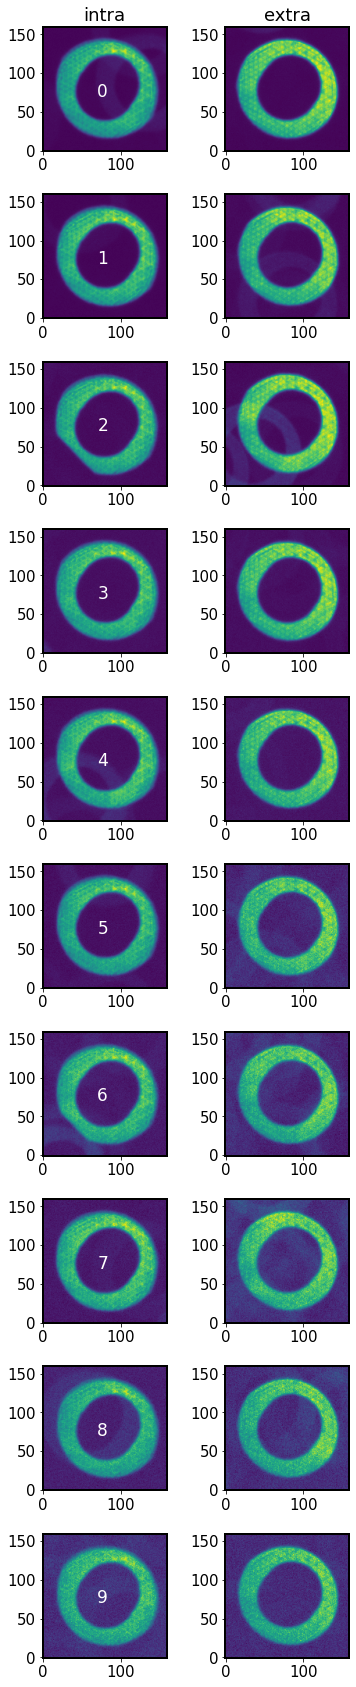

In [6]:
%matplotlib inline

nDonuts = len(intraFocalStamps)
ncols = 2
nrows = nDonuts

fig, ax = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))

for i in range(nDonuts):
    ax[i,0].imshow(intraFocalStamps[i].stamp_im.image.array, origin='lower')
    ax[i,1].imshow(extraFocalStamps[i].stamp_im.image.array, origin='lower')
    ax[i,0].text(70,70, f'{i}', fontsize=17, c='white')
    
fig.subplots_adjust(hspace=0.35)  
ax[0,0].set_title('intra')
ax[0,1].set_title('extra')
plt.savefig('R04_donuts.png', bbox_inches='tight')

### Take the first stamp pair, and change the centroid.

The following properties are attached to the donut stamp:
    
    stamp_im: lsst.afw.image.maskedImage.MaskedImageF,
    sky_position: lsst.geom.SpherePoint,
    centroid_position: lsst.geom.Point2D,
    defocal_type: str,
    detector_name: str,
    cam_name: str,
    archive_element: Optional[lsst.afw.table.io.Persistable] = None,
    comp_im: lsst.ts.wep.cwfs.CompensableImage.CompensableImage = <factory>,

The initial stamp centroid is :

In [13]:
stamp = intraFocalStamps[0]

In [14]:
stamp.centroid_position

Point2D(2288, 303)

We vary the centroid and fit for Zk for the first donut pair:

In [17]:
from lsst import geom

zernConfig = EstimateZernikesCwfsTaskConfig(initialCutoutPadding=5)
zernTask = EstimateZernikesCwfsTask(config=zernConfig)

i=0 # take the first donut pair 
intra_stamp = intraFocalStamps[i]
extra_stamp = extraFocalStamps[i]

est_zernikes_cent = {}
for offset in np.linspace(0,801,30): 
    dx = offset
    dy = -offset # centroid offset in pixels
    
    # offset the intra-focal stamp
    x,y = intra_stamp.centroid_position
    print(offset)
    new_intra_stamp = DonutStamp(intra_stamp.stamp_im,
                             intra_stamp.sky_position,
                             geom.Point2D(x+dx,y+dx),
                             intra_stamp.defocal_type,
                             intra_stamp.detector_name,
                             intra_stamp.cam_name,
                             intra_stamp.archive_element,
                             intra_stamp.comp_im)
    
    # offset the extra-focal stamp
    x,y = extra_stamp.centroid_position
    print(offset)
    new_extra_stamp = DonutStamp(extra_stamp.stamp_im,
                             extra_stamp.sky_position,
                             geom.Point2D(x+dx,y+dx),
                             extra_stamp.defocal_type,
                             extra_stamp.detector_name,
                             extra_stamp.cam_name,
                             extra_stamp.archive_element,
                             extra_stamp.comp_im)
    
    
    #calculate Zk with offset centroid
    est_zernikes_cent[offset] = zernTask.estimateZernikes(
        DonutStamps([new_intra_stamp]), 
        DonutStamps([new_extra_stamp]),
    )

0.0
0.0
radialShift = 5.25
new radialShift = 4.735162971646863
stampCenterx1=83.86783333333334
stampCentery1=77.17141666666667
radialShift = 5.25
new radialShift = 5.2453903764533
stampCenterx1=84.38083333333333
stampCentery1=76.97108333333333
27.620689655172413
27.620689655172413
radialShift = 5.25
new radialShift = 4.741673118957575
stampCenterx1=83.8724367816092
stampCentery1=77.1668132183908
radialShift = 5.25
new radialShift = 5.238887456620613
stampCenterx1=84.37622988505747
stampCentery1=76.9756867816092
55.241379310344826
55.241379310344826
radialShift = 5.25
new radialShift = 4.748183266574518
stampCenterx1=83.87704022988505
stampCentery1=77.16220977011494
radialShift = 5.25
new radialShift = 5.232384555040737
stampCenterx1=84.37162643678161
stampCentery1=76.98029022988506
82.86206896551724
82.86206896551724
radialShift = 5.25
new radialShift = 4.754693414496438
stampCenterx1=83.88164367816091
stampCentery1=77.15760632183908
radialShift = 5.25
new radialShift = 5.2258816717818

Plot the results:

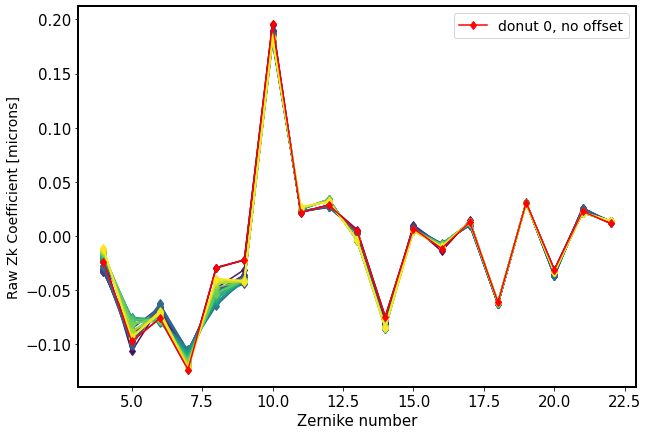

Text(0.5, 1.0, 'centroid dx=dy offset, 0 to 50 px')

In [18]:
fig,ax = plt.subplots(1,1,figsize=(10,7))

minval = min(est_zernikes_cent.keys())-1
maxval = max(est_zernikes_cent.keys())+1
bounds = np.linspace(minval, maxval) 
cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')


normCol = mpl.colors.Normalize(vmin=minval, vmax=maxval)

for key in est_zernikes_cent.keys():
    zks = est_zernikes_cent[key][0]
    ax.plot(np.arange(4, 23), zks ,'-d', color = cmap(normCol(key)), )#label=f"{key}")
    
# plot the original zk estimate for the first donut pair 
ax.plot(np.arange(4, 23), est_zernikes_cent[0][0],'-d', c='r', label=f"donut {i}, no offset") 

ax.set_xlabel("Zernike number", size=15)
ax.set_ylabel('Raw Zk Coefficient [microns]', size=14)
ax.legend(loc='upper right', fontsize=14)


#([xmin,ymin,dx,dy])
# cax = fig.add_axes([0.97,0.1,0.02,0.8])
# cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#              cax=cax, orientation='vertical',
#                    format='%.d'
#                    )
# cbar.ax.tick_params(labelsize=15,)
# cbar.set_label(label=  "centroid offset (+x,+y) [px]", size=18)
plt.show()
ax.set_title('centroid dx=dy offset, 0 to 50 px')


We see that the changes are minimal, despite large (hundreds of pixels) centroid mismatch. Why is that? Investigate in detail below:

What happens is that in `estimateZernikes`, https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/task/EstimateZernikesBase.py#L484  we do 

    configDir = getConfigDir()
    instDir = os.path.join(configDir, "cwfs", "instData")
    algoDir = os.path.join(configDir, "cwfs", "algo")
    wfEsti = WfEstimator(instDir, algoDir)
    camType = getCamType(self.instName)
    defocalDisInMm = getDefocalDisInMm(self.instName)

    wfEsti.config(
        sizeInPix=self.donutStampSize,
        camType=camType,
        opticalModel=self.opticalModel,
        defocalDisInMm=defocalDisInMm,
    )

    for donutExtra, donutIntra in zip(donutStampsExtra, donutStampsIntra):

        fieldXYExtra = donutExtra.calcFieldXY()
        fieldXYIntra = donutIntra.calcFieldXY()

        camera = donutExtra.getCamera()
        detectorExtra = camera.get(donutExtra.detector_name)
        detectorIntra = camera.get(donutIntra.detector_name)

        # Rotate any sensors that are not lined up with the focal plane.
        # Mostly just for the corner wavefront sensors. The negative sign
        # creates the correct rotation based upon closed loop tests
        # with R04 and R40 corner sensors.
        eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
        eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

        # NOTE: TS_WEP expects these images to be transposed
        # TODO: Look into this
        wfEsti.setImg(
            fieldXYExtra,
            DefocalType.Extra,
            image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T,
        )
        wfEsti.setImg(
            fieldXYIntra,
            DefocalType.Intra,
            image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T,
        )
        wfEsti.reset()
        zer4UpNm = wfEsti.calWfsErr()


i.e. we pass to `wfEstimator` the image array, `DefocalType`, and the fieldXY.

The `donutStamp.calcFieldXY` method uses  https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/task/DonutStamp.py#L162

    cam = self.getCamera()
    det = cam.get(self.detector_name)
    field_x, field_y = det.transform(self.centroid_position, PIXELS, FIELD_ANGLE)

i.e. it calculated the **field position from the centroid position**. This means that based on changed centroid information, the field information also  is updated. 

Then `wfEsti` calls `algo.runIt` method https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/WfEstimator.py#L247

which in `singleItr` does first call `compensaleImage` to `makeMask` https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/cwfs/Algorithm.py#L694 and then `imageCoCenter`, which at the end does "Shift the weighting center of donut to the center of reference image with the correction of projection of fieldX and fieldY." https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/cwfs/CompensableImage.py#L273 

So changing the `centroid` attached to donut stamp, and then checking the `imageCoCenter` , we should see the different masks. Test that on the first stamp:





In [19]:
stamp = intraFocalStamps[i]
print(stamp.centroid_position)
print(stamp.calcFieldXY())

(2288, 303)
(1.2936111111111113, -1.1763055555555557)


In [20]:
x,y = stamp.centroid_position
dx=400 # offset in pixels 
new_stamp = DonutStamp(stamp.stamp_im,
                         stamp.sky_position,
                         geom.Point2D(x+dx,y+dx),
                         stamp.defocal_type,
                         stamp.detector_name,
                         stamp.cam_name,
                         stamp.archive_element,
                         stamp.comp_im)



In [21]:
print(new_stamp.centroid_position)
print(new_stamp.calcFieldXY())

(2688, 703)
(1.2713888888888887, -1.1540833333333333)


Now follow what happens in `EstimateZernikesBase`:

In [22]:
# set  the name of the stamp below to 
# donutIntra, just like it's called in estimateZernikesBase

donutIntra = new_stamp

# we set that in https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/WfEstimator.py#L212
#WfEstimator, which passes compensableImage directly to the algorithm ...

from lsst.ts.wep.Utility import DefocalType, CamType, CentroidFindType
from scipy.ndimage import rotate

imgIntra = CompensableImage(centroidFindType=CentroidFindType.RandomWalk,)
img = imgIntra # if defocal_type is intra 

fieldXY = donutIntra.calcFieldXY()

camera = donutIntra.getCamera()

detectorIntra = camera.get(donutIntra.detector_name)

# Rotate any sensors that are not lined up with the focal plane.
# Mostly just for the corner wavefront sensors. The negative sign
# creates the correct rotation based upon closed loop tests
# with R04 and R40 corner sensors.
eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()


image = rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T

defocalType = DefocalType.Intra,

img.setImg(fieldXY, defocalType, image=image)#, imageFile=imageFile)


# Then that's what's internally in Algorithm.py called I1, I2 ..
I1 = img 



In [23]:
# initially, there isn't any mask...
I1.mask_comp

array([], dtype=int64)

Now delve into `wfEsti` and what is passed to `Algorithm.py`:

In [24]:
# it needs to be calculated, as in https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/cwfs/Algorithm.py#L694
# 
boundaryT = 1 

# the instrument is set in estimateZernikesBase()
configDir = getConfigDir()
instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")

# and then inside WfEstimator we instantiate Instrument class pointed to a given directory 
inst = Instrument(instDir)
     
    
# and inside wfEsti.config  we pass the config to Instrument class:
donutStampSize = 160
sizeInPix = donutStampSize
sizeInPix = int(sizeInPix)

instName = 'lsst'
camType = getCamType(instName)

defocalDisInMm = getDefocalDisInMm(instName)

inst.config(
            camType, 
            sizeInPix, 
            announcedDefocalDisInMm=defocalDisInMm
            )
    

In [25]:
opticalModel = 'offAxis'
model = opticalModel
I1.makeMask(inst, model, boundaryT, 1)

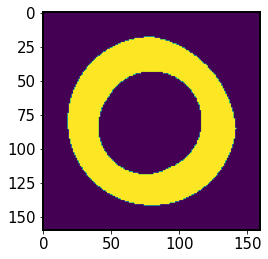

In [26]:
# now there is a mask. 
%matplotlib inline
old_mask = I1.mask_comp
plt.imshow(I1.mask_comp)

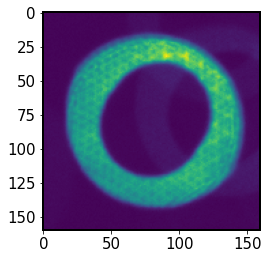

In [27]:
# and the original image
old_image = I1.getImg()
plt.imshow(I1.getImg())

In [28]:
# then we co-center the image - this does not 
# take into account the field information,
# it uses the centroidFindType 
# defined earlier when CompensableImage was initalized
# eg. here we have CentroidFindType.RandomWalk
I1.imageCoCenter(inst, debugLevel=3)

imageCoCenter: (x, y) = (   81.80,   79.81)

radialShift = 5.25
new radialShift = 5.151217567101113
stampCenterx1=84.31416666666667
stampCentery1=77.03775


In [29]:
I1._getFieldDistFromOrigin()

1.7170725223670376

the `imageCoCenter` calls  

    x1, y1 = self._image.getCenterAndR()[0:2]

which via `Image` and `CentroidDefault` call 

    imgBinary = self.getImgBinary(imgDonut)
    
--> this is offloaded to child class, eg.  CentroidRandomWalk  class https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/cwfs/CentroidRandomWalk.py#L44
    
and the resulting imgBinary is passed to  getCenterAndRfromImgBinary(imgBinary) in `centroidDefault` : 
    
    from scipy.ndimage import center_of_mass
    y, x = center_of_mass(imgBinary)
    radius = np.sqrt(np.sum(imgBinary) / np.pi)
    return x, y, radius



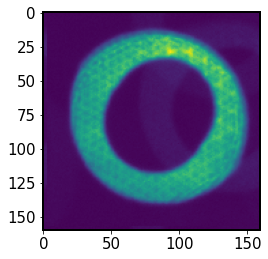

In [30]:
# the mask hasn't changed, but the image has been shifted
new_image = I1.getImg()
plt.imshow(new_image)

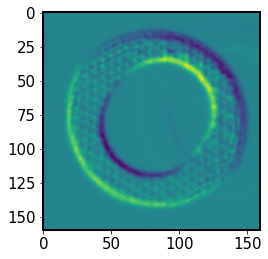

In [32]:
# show that the image has shifted slightly:
%matplotlib inline
plt.imshow(old_image-new_image)

They're not the same - it has been shifted! 

So this means that the mask is more vignetted than the donut so a wrong portion of the donut is cut out. 

### Image cocenter calculation with increasing centroid offset

Put the above in a function, so I can define a donut stamp, and get the field distance from origin:

In [33]:
from lsst.ts.wep.Utility import DefocalType, CamType, CentroidFindType
from scipy.ndimage import rotate
    
def get_comp_cocenter_image(donutIntra):
    
    # set  the name of the stamp below to 
    # donutIntra, just like it's called in estimateZernikesBase

    # we set that in https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/WfEstimator.py#L212
    #WfEstimator, which passes compensableImage directly to the algorithm ...

    imgIntra = CompensableImage(centroidFindType=CentroidFindType.RandomWalk,)
    img = imgIntra # if defocal_type is intra 

    fieldXY = donutIntra.calcFieldXY() # calculated based on centroid 
    camera = donutIntra.getCamera()
    detectorIntra = camera.get(donutIntra.detector_name)

    # Rotate any sensors that are not lined up with the focal plane.
    # Mostly just for the corner wavefront sensors. The negative sign
    # creates the correct rotation based upon closed loop tests
    # with R04 and R40 corner sensors.
    eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()
    image = rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T

    defocalType = DefocalType.Intra,

    img.setImg(fieldXY, defocalType, image=image)#, imageFile=imageFile)
    
    # Then that's what's internally in Algorithm.py called I1, I2 ..
    I1 = img 

    # initially there isn't a mask, it gets called in 
    # Algorithm.py
    # it needs to be calculated, as in https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/cwfs/Algorithm.py#L694
    # 
    boundaryT = 1 

    # the instrument is set in estimateZernikesBase()
    configDir = getConfigDir()
    instDir = os.path.join(configDir, "cwfs", "instData")
    algoDir = os.path.join(configDir, "cwfs", "algo")

    # and then inside WfEstimator we instantiate Instrument class pointed to a given directory 
    inst = Instrument(instDir)

    # and inside wfEsti.config  we pass the config to Instrument class:
    donutStampSize = 160
    sizeInPix = donutStampSize
    sizeInPix = int(sizeInPix)

    instName = 'lsst'
    camType = getCamType(instName)

    defocalDisInMm = getDefocalDisInMm(instName)

    inst.config(
                camType, 
                sizeInPix, 
                announcedDefocalDisInMm=defocalDisInMm
                )
    
    opticalModel = 'offAxis'
    model = opticalModel
    I1.makeMask(inst, model, boundaryT, 1)

    # store image before co-center 
    original_image = I1.getImg()
    
    # then we co-center the image - this does not 
    # take into account the field information,
    # it uses the centroidFindType 
    # defined earlier when CompensableImage was initalized
    # eg. here we have CentroidFindType.RandomWalk
    I1.imageCoCenter(inst, debugLevel=3)
    
    # print for information the inferred distance from the origin
    print('getFieldDistFromOrigin', I1._getFieldDistFromOrigin())
    
    cocenter_image = I1.getImg()
     
    return original_image, I1.getImg(), I1.getPaddedMask()

Choose again the first donut stamp pair.  Iterate over centroid offset, and find the image cocenter. 



In [34]:
from lsst import geom

# zernConfig = EstimateZernikesCwfsTaskConfig(initialCutoutPadding=5)
# zernTask = EstimateZernikesCwfsTask(config=zernConfig)


i=0 # take the first donut pair 
stamp = intraFocalStamps[i]
x,y = stamp.centroid_position


cocenter_images = {}
pmasks = {}
for offset in np.linspace(0,801,30): 
    dx = offset
    dy = -offset # centroid offset in pixels
    
    
    print(f'\nOffset = {offset}')
    print('Before', stamp.calcFieldXY())
    intra_stamp = DonutStamp(stamp.stamp_im,
                             stamp.sky_position,
                             geom.Point2D(x+dx,y+dx),
                             stamp.defocal_type,
                             stamp.detector_name,
                             stamp.cam_name,
                             stamp.archive_element,
                             stamp.comp_im)
    print('--> After', intra_stamp.calcFieldXY())
    orig, new, pmask = get_comp_cocenter_image(intra_stamp)
    cocenter_images[i] = new
    pmasks[i] = pmask
    i += 1 


Offset = 0.0
Before (1.2936111111111113, -1.1763055555555557)
--> After (1.2936111111111113, -1.1763055555555557)
imageCoCenter: (x, y) = (   81.80,   79.81)

radialShift = 5.25
new radialShift = 5.2453903764533
stampCenterx1=84.38083333333333
stampCentery1=76.97108333333333
getFieldDistFromOrigin 1.7484634588177668

Offset = 27.620689655172413
Before (1.2936111111111113, -1.1763055555555557)
--> After (1.2920766283524903, -1.1747710727969347)
imageCoCenter: (x, y) = (   81.80,   79.81)

radialShift = 5.25
new radialShift = 5.238887456620613
stampCenterx1=84.37622988505747
stampCentery1=76.9756867816092
getFieldDistFromOrigin 1.7462958188735378

Offset = 55.241379310344826
Before (1.2936111111111113, -1.1763055555555557)
--> After (1.2905421455938697, -1.1732365900383144)
imageCoCenter: (x, y) = (   81.80,   79.81)

radialShift = 5.25
new radialShift = 5.232384555040737
stampCenterx1=84.37162643678161
stampCentery1=76.98029022988506
getFieldDistFromOrigin 1.7441281850135788

Offset = 

imageCoCenter: (x, y) = (   81.80,   79.81)

radialShift = 5.25
new radialShift = 5.063315751087006
stampCenterx1=84.2519367816092
stampCentery1=77.09997988505746
getFieldDistFromOrigin 1.687771917029002

Offset = 801.0
Before (1.2936111111111113, -1.1763055555555557)
--> After (1.249111111111111, -1.1318055555555553)
imageCoCenter: (x, y) = (   81.80,   79.81)

radialShift = 5.25
new radialShift = 5.056813369246376
stampCenterx1=84.24733333333333
stampCentery1=77.10458333333334
getFieldDistFromOrigin 1.6856044564154586


What changes in the above is that the field distance from the origin changes from `1.7484` originally (with `dx=0`,`dy=0` px) , to `1.6856` (with `dx=801`, `dy=-801` px). Here `dx=-dy`, because we're working on a donut in R04_SW1 (intra), so increasing x (and decreasing y) brings the donut diagonally towards the field center. 

Show that the cocentered image for no offset (`0`) is different than that with large offset (`19`) by calculating the difference:

In [36]:
np.sum(cocenter_images[0]-cocenter_images[19])

-0.0075683594

Plot the difference:

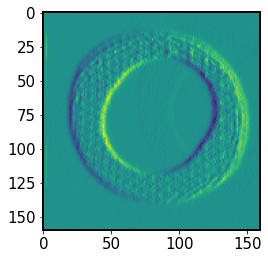

In [37]:
plt.imshow(cocenter_images[0]-cocenter_images[19])

Plot the pmask difference:

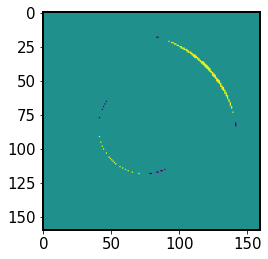

In [39]:
plt.imshow(pmasks[19]-pmasks[0])

So there is definite difference with pmasks too, although very small. This is because the centroid is not used directly, only to find the radial correction from the field. 